<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
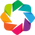

In [11]:
import numpy as np
import holoviews as hv
from holoviews import opts
import hvplot.xarray
import pandas as pd
import xarray as xr
from tqdm.notebook import tqdm


hv.extension('bokeh')

We want to simulate a two reservoir system

In [2]:
# network

import xarray as xr
import networkx as nx
import geonetworkx as gnx
import pandas as pd
from pathlib import Path
import numpy as np

In [3]:
# start with
INFLOW = {
    1: 0.001,  # don't change
    2: 0
}

g = 9.81 # m/s2

class Reservoir:
    def __init__(self, node, start_time='2000-01-01'):
        self.node = node

        self.reservoir_breadth = 100 # m
        self.reservoir_depth = 200   # m
        self.outlet_height = 0      # m
        self.outlet_diameter = 1  # m

        self.storage = 1e9            # m3
        self.inflow = 0             # m3/d
        self.storage_change = np.nan
        self.time = start_time if isinstance(start_time, pd.Timestamp) else pd.to_datetime(start_time)

        self.outlet_area = np.pi * (self.outlet_diameter / 2) ** 2

        # calculate derived properties
        self.water_height = self.storage / (self.reservoir_breadth * self.reservoir_depth)
        self.height_above_outlet = max([0, self.water_height - self.outlet_height]) # return height above outlet, or 0 if below outlet
        self.outlet_velocity = np.sqrt(2 * g * self.height_above_outlet)
        self.outlet_flow = self.outlet_area * self.outlet_velocity

        self.FIRST_RUN = 1

    def update(self, inflow, dt=1):
        """update for one time step

        Args:
            inflow (number): inflow rate (m3/d)
            dt (number): time step (1 day)
        """
        # prev_time = self.time
        # self.time += pd.Timedelta(seconds=dt)
        if self.FIRST_RUN:
            self.FIRST_RUN = 0  # if this is the first run, don't advance time
        else:
            self.time += pd.Timedelta(days=dt)
        
        self.inflow = inflow
        
        last_storage = self.storage
        self.storage += self.inflow * dt

        self.water_height = self.storage / (self.reservoir_breadth * self.reservoir_depth)
        self.height_above_outlet = max([0, self.water_height - self.outlet_height])

        self.outlet_velocity = np.sqrt(2 * g * self.height_above_outlet)
        self.outlet_flow = self.outlet_area * self.outlet_velocity

        self.storage -= self.outlet_flow * dt # update storage again after outflow is calcualted
        self.storage_change = self.storage - last_storage # calculate storage change
    
    def dumpds(self):
        return xr.Dataset(
            data_vars = dict(
                storage=(['node', 'time'], [[self.storage]]),
                inflow=(['node', 'time'], [[self.inflow]]),
                outflow=(['node', 'time'], [[self.outlet_flow]]),
                storage_change=(['node', 'time'], [[self.storage_change]]),
                water_height=(['node', 'time'], [[self.water_height]]),
                height_above_outlet=(['node', 'time'], [[self.height_above_outlet]]),
                outlet_velocity=(['node', 'time'], [[self.outlet_velocity]]),
            ),
            coords={
                'time': [self.time],
                'node': [self.node]
            }
        )

class ReservoirNetwork(nx.DiGraph):
    def __init__(self, network, start_time, *args, **kwargs):
        super().__init__(network, *args, **kwargs)
        # self.data = xr.open_dataset(data) if isinstance(data, str) \
        #     else data if isinstance(data, xr.Dataset) \
        #     else ValueError("Must provide either path of data file or as xr.Dataset")
        self.data = xr.Dataset(
            coords={
                'node': list(self.nodes),
                'time': pd.date_range(start_time, periods=1, freq='1D')
            }
        ) 
        self.network = {node: Reservoir(node) for node in self.nodes}
        self.time = start_time

        self.FIRST_RUN = 1

    def create_field(self, var, fill_value=0.0):
        """Create a new field if not already present in self.data"""
        if var not in self.data.variables:
            self.data[var] = xr.DataArray(
                data=np.full((len(self.nodes), len(self.data.time)), fill_value),
                dims=['node', 'time'],
                coords={'node': self.nodes, 'time': self.data.time}
            )

    def insert_new_time_step(self, time):
        """Insert a new time step and fill with np.nan for all variables"""
        if time not in self.data.time:
            data_vars = {}
            for var in self.data.variables:
                if var not in ['node', 'time']:
                    data_vars[var] = (['node', 'time'], np.full((len(self.nodes), 1), np.nan))
            new_timestep_ds = xr.Dataset(data_vars=data_vars, coords={'node': self.nodes, 'time': [self.time]})
            # self.data = xr.merge([self.data, new_timestep_ds])
            self.data = xr.concat([self.data, new_timestep_ds], dim='time')
        else:
            raise ValueError(f"Time {time} already exists in data.")

    def update(self, forcings, dt=1, algorithm='simple'):
        """Update the reservoir network for one time step.

        Args:
            dt (int, optional): time step in days. Defaults to 1 day.
            algorithm (str, optional): Defaults to 'simple'.
                - hydraulic - outflow from reservoir is simulated to estimate storage change. 
                - simple - requires storage change and unregulated inflow of previous node.
        """

        if self.FIRST_RUN:
            self.create_field('inflow', np.nan)
            self.create_field('outflow', np.nan)
            self.create_field('regulated_inflow', np.nan)
            self.create_field('unregulated_inflow', np.nan)
            self.create_field('storage', np.nan)
            self.create_field('storage_change', np.nan)
            self.create_field('water_height', np.nan)
            self.create_field('height_above_outlet', np.nan)
            self.FIRST_RUN = 0
        else:
            self.time += pd.Timedelta(days=dt)
            self.insert_new_time_step(self.time)
        
        # insert forcings into data
        for var in forcings.variables:
            if var not in ['node', 'time']:
                if var not in self.data.variables:
                    self.data[var] = forcings[var].sel(time=self.time)
                else:
                    self.data[var].loc[dict(time=self.time)] = forcings[var].sel(time=self.time)
        
        if algorithm == 'hydraulic':
            self._alg_hydraulic(forcings, dt)

        # if algorithm == 'simple':
            # for node in list(nx.topological_sort(self)):
            #     storage_change = float(self.data['storage_change'].sel(node=node, time=time))
            #     natural_inflow = float(self.data['natural_inflow'].sel(node=node, time=time))

            #     upstreams = list(self.predecessors(node))
            #     upstream_outflow = 0.0
            #     upstream_natural_inflow = 0.0
            #     if len(upstreams) > 0:
            #         time_lags = [time - pd.to_timedelta(round(self.get_edge_data(upstream, node)['travel_time']), 'd') for upstream in upstreams]
            #         upstream_outflow = sum([float(self.data['outflow'].sel(node=n, time=t)) for n, t in zip(upstreams, time_lags)])
            #         upstream_natural_inflow = sum([float(self.data['natural_inflow'].sel(node=n, time=t)) for n, t in zip(upstreams, time_lags)])
                
            #     regulated_inflow = max([0, float(natural_inflow - upstream_natural_inflow + upstream_outflow)])
            #     outflow = max([0, regulated_inflow - storage_change])

            #     self.data['regulated_inflow'].loc[dict(node=node, time=time)] = regulated_inflow
            #     self.data['outflow'].loc[dict(node=node, time=time)] = outflow

    def _alg_hydraulic(self, forcings, dt):
        for node in list(nx.topological_sort(self)):
            # get reservoir object
            res = self.network[node]
            # get inflow for this node
            inflow = (forcings['inflow'].sel(node=node, time=slice(self.time - pd.Timedelta(days=dt), self.time)).mean() * dt).data # m3/s

            # if there are upstream nodes, the inflow 
            regulated_inflow = 0
            upstreams = list(self.predecessors(node))
            if len(upstreams) > 0:
                # sum the outflow from upstream nodes to the inflow of this node
                regulated_inflow += sum([self.data['outflow'].sel(node=n, time=self.time) for n in upstreams]).data
                inflow += regulated_inflow

            # update data
            self.data['inflow'].loc[dict(node=node, time=self.time)] = inflow
            self.data['regulated_inflow'].loc[dict(node=node, time=self.time)] = regulated_inflow
            self.data['unregulated_inflow'].loc[dict(node=node, time=self.time)] = inflow - regulated_inflow

            res.update(inflow, 1)
            # self.data.update(res.dumpds())
            res_data = res.dumpds()
            self.data = xr.merge([self.data, res_data])  # compat='override' will ensure that any existing variables (such as inflow, which was first initialized according to forcings) will be overwritten by the model outputs, which also includes inflow from upstream nodes.


# Run model using constant inflow of 100 m3/d

In [4]:
## RUN MODEL
start_time = pd.to_datetime('2000-01-01')
time_steps = 1e3

# define network
G = nx.DiGraph()
G.add_nodes_from([
    (1, {"name": "A"}),
    (2, {"name": "B"}),
])
G.add_edge(1, 2)

inflow_data = xr.DataArray(
    data=np.array([[1000., 0.] for _ in np.arange(time_steps)]),
    dims=['time', 'node'],
    coords={'node': [1, 2], 'time': pd.date_range(start_time, periods=time_steps, freq='1D')}
)
forcings = xr.Dataset(
    data_vars={
        'inflow': inflow_data,
    }
)

data = xr.Dataset(
    coords={
        'node': [1, 2],
        'time': pd.date_range(start_time, periods=1, freq='1D')
    }
)

reservoir_network = ReservoirNetwork(G, start_time)

for timestep in tqdm(np.arange(time_steps)):
    reservoir_network.update(forcings, 1, 'hydraulic')

reservoir_network.data

  0%|          | 0/1000 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:              (node: 2, time: 1000)
Coordinates:
  * node                 (node) int64 1 2
  * time                 (time) datetime64[ns] 2000-01-01 ... 2002-09-26
Data variables:
    inflow               (node, time) float64 1e+03 1e+03 1e+03 ... 778.0 778.0
    outflow              (node, time) float64 777.9 777.9 777.9 ... 777.9 777.9
    regulated_inflow     (node, time) float64 0.0 0.0 0.0 ... 778.0 778.0 778.0
    unregulated_inflow   (node, time) float64 1e+03 1e+03 1e+03 ... 0.0 0.0 0.0
    storage              (node, time) float64 1e+09 1e+09 1e+09 ... 1e+09 1e+09
    storage_change       (node, time) float64 222.1 222.1 ... 0.08626 0.08635
    water_height         (node, time) float64 5e+04 5e+04 5e+04 ... 5e+04 5e+04
    height_above_outlet  (node, time) float64 5e+04 5e+04 5e+04 ... 5e+04 5e+04
    outlet_velocity      (node, time) float64 990.5 990.5 990.5 ... 990.5 990.5

In [5]:
results_hvds = hv.Dataset(reservoir_network.data)

inflow_plot = results_hvds.to(hv.Curve, 'time', 'inflow', 'node').layout('node').cols(1).opts(title='inflow')

# create stacked area plots
regulated_area_plot = results_hvds.to(hv.Area, 'time', 'regulated_inflow', 'node', label='regulated flow').opts(alpha=0.2).layout('node').cols(1).opts(title='regulated inflow')
unregulated_area_plot = results_hvds.to(hv.Area, 'time', 'unregulated_inflow', 'node', label='unregulated flow').opts(alpha=0.2).layout('node').cols(1).opts(title='unregulated inflow')
overlay = (regulated_area_plot * unregulated_area_plot)
stacked = []
for inner_overlay, inner_inflow, node in zip(overlay, inflow_plot, reservoir_network.data['node'].data):
    print(inner_overlay, inner_inflow)
    stacked.append((hv.Area.stack(inner_overlay)*inner_inflow).opts(ylabel='inflow (m3/d)', title=f'Node {node}'))
inflow_distribution = hv.Layout(stacked).cols(1)

inflow_distribution

:Overlay
   .Area.Regulated_flow   :Area   [time]   (regulated_inflow)
   .Area.Unregulated_flow :Area   [time]   (unregulated_inflow) :Curve   [time]   (inflow)
:Overlay
   .Area.Regulated_flow   :Area   [time]   (regulated_inflow)
   .Area.Unregulated_flow :Area   [time]   (unregulated_inflow) :Curve   [time]   (inflow)


/water2/pdas47/2023_01_24-river-regulation/.env/lib/python3.10/site-packages/holoviews/plotting/bokeh/plot.py:987: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  layout_plot = gridplot(
/water2/pdas47/2023_01_24-river-regulation/.env/lib/python3.10/site-packages/holoviews/plotting/bokeh/plot.py:987: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  layout_plot = gridplot(


:Layout
   .Overlay.I  :Overlay
      .Area.Regulated_flow   :Area   [time]   (regulated_inflow,Baseline)
      .Area.Unregulated_flow :Area   [time]   (unregulated_inflow,Baseline)
      .Curve.I               :Curve   [time]   (inflow)
   .Overlay.II :Overlay
      .Area.Regulated_flow   :Area   [time]   (regulated_inflow,Baseline)
      .Area.Unregulated_flow :Area   [time]   (unregulated_inflow,Baseline)
      .Curve.I               :Curve   [time]   (inflow)

In [12]:
inflow_curve = results_hvds.to(hv.Curve, 'time', 'inflow', 'node').layout('node').cols(1).opts(title='inflow')
outflow_curve = results_hvds.to(hv.Curve, 'time', 'outflow', 'node').layout('node').cols(1).opts(title='outflow')
storage_curve = results_hvds.to(hv.Curve, 'time', 'storage', 'node').layout('node').cols(1).opts(title='storage')

(inflow_curve + outflow_curve + storage_curve).opts(opts.Curve(axiswise=True))

/water2/pdas47/2023_01_24-river-regulation/.env/lib/python3.10/site-packages/holoviews/plotting/bokeh/plot.py:987: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  layout_plot = gridplot(
/water2/pdas47/2023_01_24-river-regulation/.env/lib/python3.10/site-packages/holoviews/plotting/bokeh/plot.py:987: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  layout_plot = gridplot(
/water2/pdas47/2023_01_24-river-regulation/.env/lib/python3.10/site-packages/holoviews/plotting/bokeh/plot.py:987: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  layout_plot = gridplot(
/water2/pdas47/2023_01_24-river-regulation/.env/lib/python3.10/site-packages/holoviews/plotting/bokeh/plot.py:987: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  layout_plot = gridplot(
/water2/pdas47/2

:Layout
   .NdLayout.I   :NdLayout   [node]
      :Curve   [time]   (inflow)
   .NdLayout.II  :NdLayout   [node]
      :Curve   [time]   (outflow)
   .NdLayout.III :NdLayout   [node]
      :Curve   [time]   (storage)

# Now let's try with a pulse of 100 m3/d, for 7 days, otherwise constant inflow of 20 m3/d

In [7]:
start_time = pd.to_datetime('2000-01-01')
time_steps = 1e3

inflow_data = xr.DataArray(
    data=np.array([[100., 0.] for _ in np.arange(time_steps)]),
    dims=['time', 'node'],
    coords={'node': [1, 2], 'time': pd.date_range(start_time, periods=time_steps, freq='1D')}
)
inflow_data.loc[dict(time=slice('2000-05-01', '2000-05-30'), node=1)] = 1e4
inflow_data.loc[dict(time=slice('2000-10-01', '2000-10-30'), node=1)] = 1e4
inflow_data.loc[dict(time=slice('2000-03-01', '2000-03-30'), node=1)] = 1e4

forcings = xr.Dataset(
    data_vars={
        'inflow': inflow_data,
    }
)

data = xr.Dataset(
    coords={
        'node': [1, 2],
        'time': pd.date_range(start_time, periods=1, freq='1D')
    }
)

In [8]:
reservoir_network = ReservoirNetwork(G, start_time)

for timestep in tqdm(np.arange(time_steps)):
    reservoir_network.update(forcings, 1, 'hydraulic')

reservoir_network.data

  0%|          | 0/1000 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:              (node: 2, time: 1000)
Coordinates:
  * node                 (node) int64 1 2
  * time                 (time) datetime64[ns] 2000-01-01 ... 2002-09-26
Data variables:
    inflow               (node, time) float64 100.0 100.0 100.0 ... 778.0 778.0
    outflow              (node, time) float64 777.9 777.9 777.9 ... 777.9 777.9
    regulated_inflow     (node, time) float64 0.0 0.0 0.0 ... 778.0 778.0 778.0
    unregulated_inflow   (node, time) float64 100.0 100.0 100.0 ... 0.0 0.0 0.0
    storage              (node, time) float64 1e+09 1e+09 1e+09 ... 1e+09 1e+09
    storage_change       (node, time) float64 -677.9 -677.9 ... 0.08302 0.08276
    water_height         (node, time) float64 5e+04 5e+04 5e+04 ... 5e+04 5e+04
    height_above_outlet  (node, time) float64 5e+04 5e+04 5e+04 ... 5e+04 5e+04
    outlet_velocity      (node, time) float64 990.5 990.5 990.5 ... 990.5 990.5

In [9]:
results_hvds = hv.Dataset(reservoir_network.data)

inflow_plot = results_hvds.to(hv.Curve, 'time', 'inflow', 'node').layout('node').cols(1).opts(title='inflow')

# create stacked area plots
regulated_area_plot = results_hvds.to(hv.Area, 'time', 'regulated_inflow', 'node', label='regulated flow').opts(alpha=0.2).layout('node').cols(1).opts(title='regulated inflow')
unregulated_area_plot = results_hvds.to(hv.Area, 'time', 'unregulated_inflow', 'node', label='unregulated flow').opts(alpha=0.2).layout('node').cols(1).opts(title='unregulated inflow')
overlay = (regulated_area_plot * unregulated_area_plot)
stacked = []
for inner_overlay, inner_inflow, node in zip(overlay, inflow_plot, reservoir_network.data['node'].data):
    print(inner_overlay, inner_inflow)
    stacked.append((hv.Area.stack(inner_overlay)*inner_inflow).opts(ylabel='inflow (m3/d)', title=f'Node {node}'))
inflow_distribution = hv.Layout(stacked).cols(1)

inflow_distribution

:Overlay
   .Area.Regulated_flow   :Area   [time]   (regulated_inflow)
   .Area.Unregulated_flow :Area   [time]   (unregulated_inflow) :Curve   [time]   (inflow)
:Overlay
   .Area.Regulated_flow   :Area   [time]   (regulated_inflow)
   .Area.Unregulated_flow :Area   [time]   (unregulated_inflow) :Curve   [time]   (inflow)


/water2/pdas47/2023_01_24-river-regulation/.env/lib/python3.10/site-packages/holoviews/plotting/bokeh/plot.py:987: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  layout_plot = gridplot(
/water2/pdas47/2023_01_24-river-regulation/.env/lib/python3.10/site-packages/holoviews/plotting/bokeh/plot.py:987: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  layout_plot = gridplot(


:Layout
   .Overlay.I  :Overlay
      .Area.Regulated_flow   :Area   [time]   (regulated_inflow,Baseline)
      .Area.Unregulated_flow :Area   [time]   (unregulated_inflow,Baseline)
      .Curve.I               :Curve   [time]   (inflow)
   .Overlay.II :Overlay
      .Area.Regulated_flow   :Area   [time]   (regulated_inflow,Baseline)
      .Area.Unregulated_flow :Area   [time]   (unregulated_inflow,Baseline)
      .Curve.I               :Curve   [time]   (inflow)

In [10]:
inflow_curve = results_hvds.to(hv.Curve, 'time', 'inflow', 'node').layout('node').cols(1).opts(title='inflow')
outflow_curve = results_hvds.to(hv.Curve, 'time', 'outflow', 'node').layout('node').cols(1).opts(title='outflow')
storage_curve = results_hvds.to(hv.Curve, 'time', 'storage', 'node').layout('node').cols(1).opts(title='storage')

(inflow_curve + outflow_curve + storage_curve).opts()

/water2/pdas47/2023_01_24-river-regulation/.env/lib/python3.10/site-packages/holoviews/plotting/bokeh/plot.py:987: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  layout_plot = gridplot(
/water2/pdas47/2023_01_24-river-regulation/.env/lib/python3.10/site-packages/holoviews/plotting/bokeh/plot.py:987: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  layout_plot = gridplot(
/water2/pdas47/2023_01_24-river-regulation/.env/lib/python3.10/site-packages/holoviews/plotting/bokeh/plot.py:987: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  layout_plot = gridplot(
/water2/pdas47/2023_01_24-river-regulation/.env/lib/python3.10/site-packages/holoviews/plotting/bokeh/plot.py:987: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  layout_plot = gridplot(
/water2/pdas47/2

:Layout
   .NdLayout.I   :NdLayout   [node]
      :Curve   [time]   (inflow)
   .NdLayout.II  :NdLayout   [node]
      :Curve   [time]   (outflow)
   .NdLayout.III :NdLayout   [node]
      :Curve   [time]   (storage)